# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!pip install --quiet matplotlib==2.2.0 tensorflow==1.4.0 tensorflow-gpu==1.4.0

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

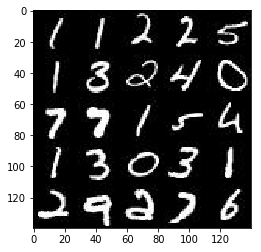

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

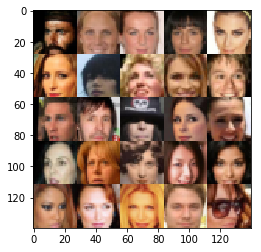

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='inputs_z')
    learnrate = tf.placeholder(tf.float32, name='learnrate')

    return inputs_real, inputs_z, learnrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.nn.leaky_relu(x, alpha=.1)
        x = tf.layers.conv2d(x, 128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.dropout(x, rate=.2)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha=.1)
        x = tf.layers.conv2d(x, 256, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.dropout(x, .2)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha=.1)
        
        x = tf.layers.flatten(x)
        logits = tf.layers.dense(x, 1)
        out = tf.nn.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        x = tf.layers.dense(z, 7*7*1024)
        x = tf.reshape(x, (-1, 7, 7, 1024))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=.2)
        x = tf.layers.conv2d_transpose(x, 1024, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=.2)
        x = tf.layers.conv2d(x, 1024, 5, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x)
        x = tf.layers.conv2d_transpose(x, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=.2)
        x = tf.layers.conv2d_transpose(x, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=.2)
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=.2)        
        x = tf.layers.max_pooling2d(x, pool_size=2, strides=2)
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha=.2)        
        logits = tf.layers.conv2d(x, out_channel_dim, 5, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    width, height, channel = data_shape[1], data_shape[2], data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, channel, data_image_mode)

        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2..., step 10 Discriminator Loss: 0.7902... Generator Loss: 1.4010
Epoch 1/2..., step 20 Discriminator Loss: 0.8802... Generator Loss: 1.2501
Epoch 1/2..., step 30 Discriminator Loss: 1.9262... Generator Loss: 0.3701
Epoch 1/2..., step 40 Discriminator Loss: 0.8080... Generator Loss: 1.2165
Epoch 1/2..., step 50 Discriminator Loss: 2.7622... Generator Loss: 3.9546
Epoch 1/2..., step 60 Discriminator Loss: 1.7608... Generator Loss: 2.9619
Epoch 1/2..., step 70 Discriminator Loss: 1.9705... Generator Loss: 1.9854
Epoch 1/2..., step 80 Discriminator Loss: 1.5472... Generator Loss: 0.6078
Epoch 1/2..., step 90 Discriminator Loss: 1.2910... Generator Loss: 1.0130
Epoch 1/2..., step 100 Discriminator Loss: 1.5577... Generator Loss: 1.4987


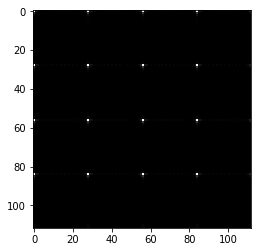

Epoch 1/2..., step 110 Discriminator Loss: 1.3546... Generator Loss: 1.2170
Epoch 1/2..., step 120 Discriminator Loss: 1.3281... Generator Loss: 1.2466
Epoch 1/2..., step 130 Discriminator Loss: 1.2472... Generator Loss: 0.7594
Epoch 1/2..., step 140 Discriminator Loss: 1.4489... Generator Loss: 1.2561
Epoch 1/2..., step 150 Discriminator Loss: 1.3957... Generator Loss: 0.7483
Epoch 1/2..., step 160 Discriminator Loss: 1.4219... Generator Loss: 0.6523
Epoch 1/2..., step 170 Discriminator Loss: 1.4278... Generator Loss: 0.6464
Epoch 1/2..., step 180 Discriminator Loss: 1.4338... Generator Loss: 0.6273
Epoch 1/2..., step 190 Discriminator Loss: 1.3650... Generator Loss: 0.7336
Epoch 1/2..., step 200 Discriminator Loss: 1.3585... Generator Loss: 0.8341


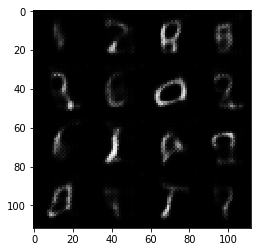

Epoch 1/2..., step 210 Discriminator Loss: 1.3220... Generator Loss: 0.8301
Epoch 1/2..., step 220 Discriminator Loss: 1.5425... Generator Loss: 1.4847
Epoch 1/2..., step 230 Discriminator Loss: 1.3329... Generator Loss: 0.6581
Epoch 1/2..., step 240 Discriminator Loss: 1.3747... Generator Loss: 0.7432
Epoch 1/2..., step 250 Discriminator Loss: 1.3611... Generator Loss: 0.6636
Epoch 1/2..., step 260 Discriminator Loss: 1.3419... Generator Loss: 0.7018
Epoch 1/2..., step 270 Discriminator Loss: 1.4422... Generator Loss: 0.5694
Epoch 1/2..., step 280 Discriminator Loss: 1.3714... Generator Loss: 0.6702
Epoch 1/2..., step 290 Discriminator Loss: 1.2413... Generator Loss: 0.7745
Epoch 1/2..., step 300 Discriminator Loss: 1.2909... Generator Loss: 1.0354


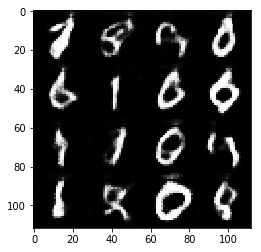

Epoch 1/2..., step 310 Discriminator Loss: 1.4431... Generator Loss: 0.9728
Epoch 1/2..., step 320 Discriminator Loss: 1.3249... Generator Loss: 0.7195
Epoch 1/2..., step 330 Discriminator Loss: 1.3474... Generator Loss: 0.9332
Epoch 1/2..., step 340 Discriminator Loss: 1.2251... Generator Loss: 0.9434
Epoch 1/2..., step 350 Discriminator Loss: 1.2690... Generator Loss: 0.9328
Epoch 1/2..., step 360 Discriminator Loss: 1.4265... Generator Loss: 1.3753
Epoch 1/2..., step 370 Discriminator Loss: 1.3171... Generator Loss: 0.7125
Epoch 1/2..., step 380 Discriminator Loss: 1.3057... Generator Loss: 0.7741
Epoch 1/2..., step 390 Discriminator Loss: 1.2285... Generator Loss: 1.0374
Epoch 1/2..., step 400 Discriminator Loss: 1.3180... Generator Loss: 0.8208


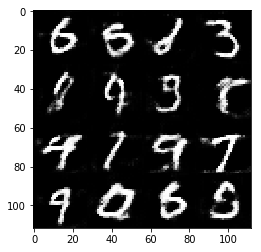

Epoch 1/2..., step 410 Discriminator Loss: 1.2860... Generator Loss: 0.9548
Epoch 1/2..., step 420 Discriminator Loss: 1.5132... Generator Loss: 1.3588
Epoch 1/2..., step 430 Discriminator Loss: 1.3027... Generator Loss: 1.0109
Epoch 1/2..., step 440 Discriminator Loss: 1.3268... Generator Loss: 0.6592
Epoch 1/2..., step 450 Discriminator Loss: 1.3008... Generator Loss: 1.1083
Epoch 1/2..., step 460 Discriminator Loss: 1.3272... Generator Loss: 1.0608
Epoch 1/2..., step 470 Discriminator Loss: 1.3824... Generator Loss: 1.0567
Epoch 1/2..., step 480 Discriminator Loss: 1.3848... Generator Loss: 0.7022
Epoch 1/2..., step 490 Discriminator Loss: 1.3469... Generator Loss: 0.7167
Epoch 1/2..., step 500 Discriminator Loss: 1.4692... Generator Loss: 0.5229


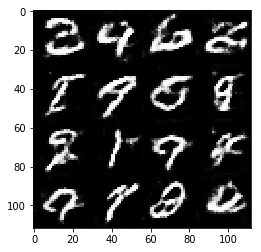

Epoch 1/2..., step 510 Discriminator Loss: 1.2749... Generator Loss: 0.9371
Epoch 1/2..., step 520 Discriminator Loss: 1.3456... Generator Loss: 1.0851
Epoch 1/2..., step 530 Discriminator Loss: 1.2259... Generator Loss: 0.9415
Epoch 1/2..., step 540 Discriminator Loss: 1.3205... Generator Loss: 0.8545
Epoch 1/2..., step 550 Discriminator Loss: 1.3612... Generator Loss: 0.6154
Epoch 1/2..., step 560 Discriminator Loss: 1.3501... Generator Loss: 0.7491
Epoch 1/2..., step 570 Discriminator Loss: 1.2725... Generator Loss: 0.9712
Epoch 1/2..., step 580 Discriminator Loss: 1.2410... Generator Loss: 1.1667
Epoch 1/2..., step 590 Discriminator Loss: 1.4336... Generator Loss: 1.0577
Epoch 1/2..., step 600 Discriminator Loss: 1.4151... Generator Loss: 0.7346


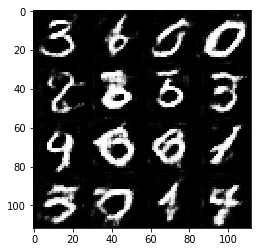

Epoch 1/2..., step 610 Discriminator Loss: 1.3804... Generator Loss: 1.1510
Epoch 1/2..., step 620 Discriminator Loss: 1.3871... Generator Loss: 1.0165
Epoch 1/2..., step 630 Discriminator Loss: 1.3668... Generator Loss: 0.6707
Epoch 1/2..., step 640 Discriminator Loss: 1.3253... Generator Loss: 0.7767
Epoch 1/2..., step 650 Discriminator Loss: 1.3906... Generator Loss: 0.5603
Epoch 1/2..., step 660 Discriminator Loss: 1.3117... Generator Loss: 1.0255
Epoch 1/2..., step 670 Discriminator Loss: 1.3450... Generator Loss: 0.8133
Epoch 1/2..., step 680 Discriminator Loss: 1.3450... Generator Loss: 0.9087
Epoch 1/2..., step 690 Discriminator Loss: 1.2877... Generator Loss: 1.0392
Epoch 1/2..., step 700 Discriminator Loss: 1.3487... Generator Loss: 1.0051


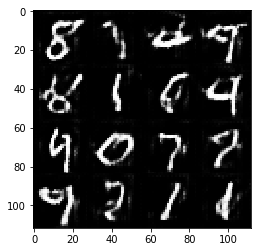

Epoch 1/2..., step 710 Discriminator Loss: 1.3343... Generator Loss: 0.9788
Epoch 1/2..., step 720 Discriminator Loss: 1.3536... Generator Loss: 0.7147
Epoch 1/2..., step 730 Discriminator Loss: 1.3983... Generator Loss: 0.6470
Epoch 1/2..., step 740 Discriminator Loss: 1.2688... Generator Loss: 0.8858
Epoch 1/2..., step 750 Discriminator Loss: 1.3656... Generator Loss: 0.7241
Epoch 1/2..., step 760 Discriminator Loss: 1.3749... Generator Loss: 0.6228
Epoch 1/2..., step 770 Discriminator Loss: 1.2871... Generator Loss: 0.9763
Epoch 1/2..., step 780 Discriminator Loss: 1.2322... Generator Loss: 0.8977
Epoch 1/2..., step 790 Discriminator Loss: 1.3050... Generator Loss: 0.6728
Epoch 1/2..., step 800 Discriminator Loss: 1.3062... Generator Loss: 0.6668


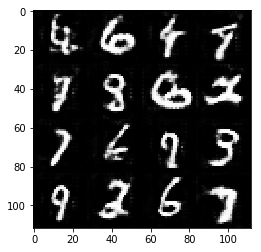

Epoch 1/2..., step 810 Discriminator Loss: 1.3433... Generator Loss: 0.7981
Epoch 1/2..., step 820 Discriminator Loss: 1.3401... Generator Loss: 0.8244
Epoch 1/2..., step 830 Discriminator Loss: 1.3879... Generator Loss: 0.9615
Epoch 1/2..., step 840 Discriminator Loss: 1.3928... Generator Loss: 0.9554
Epoch 1/2..., step 850 Discriminator Loss: 1.3179... Generator Loss: 0.9649
Epoch 1/2..., step 860 Discriminator Loss: 1.3923... Generator Loss: 0.9565
Epoch 1/2..., step 870 Discriminator Loss: 1.3511... Generator Loss: 0.7185
Epoch 1/2..., step 880 Discriminator Loss: 1.3964... Generator Loss: 0.6310
Epoch 1/2..., step 890 Discriminator Loss: 1.3699... Generator Loss: 0.6648
Epoch 1/2..., step 900 Discriminator Loss: 1.3238... Generator Loss: 1.0483


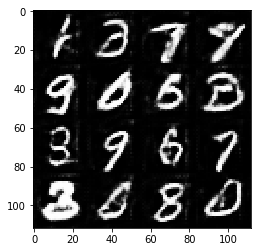

Epoch 1/2..., step 910 Discriminator Loss: 1.3980... Generator Loss: 0.6427
Epoch 1/2..., step 920 Discriminator Loss: 1.3221... Generator Loss: 0.7129
Epoch 1/2..., step 930 Discriminator Loss: 1.3327... Generator Loss: 0.8082
Epoch 2/2..., step 940 Discriminator Loss: 1.3473... Generator Loss: 0.6521
Epoch 2/2..., step 950 Discriminator Loss: 1.3021... Generator Loss: 0.9895
Epoch 2/2..., step 960 Discriminator Loss: 1.2529... Generator Loss: 0.8227
Epoch 2/2..., step 970 Discriminator Loss: 1.3986... Generator Loss: 0.7610
Epoch 2/2..., step 980 Discriminator Loss: 1.3479... Generator Loss: 0.7151
Epoch 2/2..., step 990 Discriminator Loss: 1.3173... Generator Loss: 0.7162
Epoch 2/2..., step 1000 Discriminator Loss: 1.3315... Generator Loss: 0.7260


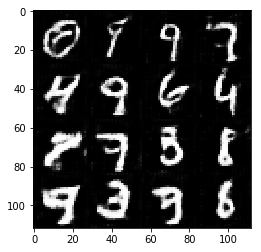

Epoch 2/2..., step 1010 Discriminator Loss: 1.4141... Generator Loss: 0.5998
Epoch 2/2..., step 1020 Discriminator Loss: 1.3497... Generator Loss: 0.6269
Epoch 2/2..., step 1030 Discriminator Loss: 1.3857... Generator Loss: 0.6306
Epoch 2/2..., step 1040 Discriminator Loss: 1.3911... Generator Loss: 0.7006
Epoch 2/2..., step 1050 Discriminator Loss: 1.2272... Generator Loss: 0.9106
Epoch 2/2..., step 1060 Discriminator Loss: 1.3070... Generator Loss: 0.9181
Epoch 2/2..., step 1070 Discriminator Loss: 1.3315... Generator Loss: 0.6914
Epoch 2/2..., step 1080 Discriminator Loss: 1.3487... Generator Loss: 0.8615
Epoch 2/2..., step 1090 Discriminator Loss: 1.3564... Generator Loss: 0.6264
Epoch 2/2..., step 1100 Discriminator Loss: 1.3646... Generator Loss: 0.8051


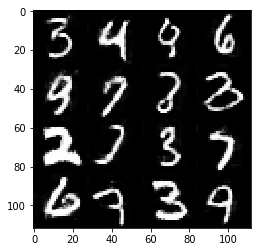

Epoch 2/2..., step 1110 Discriminator Loss: 1.3116... Generator Loss: 0.8284
Epoch 2/2..., step 1120 Discriminator Loss: 1.2932... Generator Loss: 0.7624
Epoch 2/2..., step 1130 Discriminator Loss: 1.3465... Generator Loss: 0.6890
Epoch 2/2..., step 1140 Discriminator Loss: 1.3225... Generator Loss: 0.6712
Epoch 2/2..., step 1150 Discriminator Loss: 1.3136... Generator Loss: 0.7356
Epoch 2/2..., step 1160 Discriminator Loss: 1.3939... Generator Loss: 0.7098
Epoch 2/2..., step 1170 Discriminator Loss: 1.3111... Generator Loss: 1.0535
Epoch 2/2..., step 1180 Discriminator Loss: 1.3025... Generator Loss: 0.7965
Epoch 2/2..., step 1190 Discriminator Loss: 1.3205... Generator Loss: 0.7604
Epoch 2/2..., step 1200 Discriminator Loss: 1.3308... Generator Loss: 0.9244


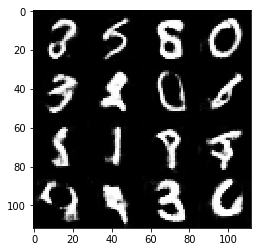

Epoch 2/2..., step 1210 Discriminator Loss: 1.2959... Generator Loss: 0.8827
Epoch 2/2..., step 1220 Discriminator Loss: 1.3803... Generator Loss: 0.5865
Epoch 2/2..., step 1230 Discriminator Loss: 1.3819... Generator Loss: 0.5903
Epoch 2/2..., step 1240 Discriminator Loss: 1.4064... Generator Loss: 0.6416
Epoch 2/2..., step 1250 Discriminator Loss: 1.3373... Generator Loss: 0.8736
Epoch 2/2..., step 1260 Discriminator Loss: 1.3855... Generator Loss: 0.6208
Epoch 2/2..., step 1270 Discriminator Loss: 1.3385... Generator Loss: 0.7763
Epoch 2/2..., step 1280 Discriminator Loss: 1.3348... Generator Loss: 0.7857
Epoch 2/2..., step 1290 Discriminator Loss: 1.3411... Generator Loss: 0.7070
Epoch 2/2..., step 1300 Discriminator Loss: 1.3882... Generator Loss: 0.7300


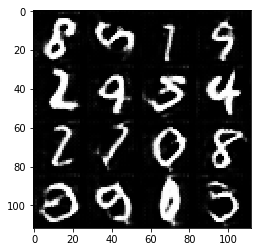

Epoch 2/2..., step 1310 Discriminator Loss: 1.3399... Generator Loss: 0.6620
Epoch 2/2..., step 1320 Discriminator Loss: 1.3392... Generator Loss: 0.7504
Epoch 2/2..., step 1330 Discriminator Loss: 1.3088... Generator Loss: 0.8146
Epoch 2/2..., step 1340 Discriminator Loss: 1.3834... Generator Loss: 1.1572
Epoch 2/2..., step 1350 Discriminator Loss: 1.3465... Generator Loss: 0.8026
Epoch 2/2..., step 1360 Discriminator Loss: 1.3153... Generator Loss: 0.8556
Epoch 2/2..., step 1370 Discriminator Loss: 1.3411... Generator Loss: 1.0786
Epoch 2/2..., step 1380 Discriminator Loss: 1.3240... Generator Loss: 0.9064
Epoch 2/2..., step 1390 Discriminator Loss: 1.3882... Generator Loss: 0.5800
Epoch 2/2..., step 1400 Discriminator Loss: 1.3708... Generator Loss: 0.7333


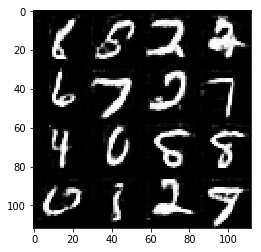

Epoch 2/2..., step 1410 Discriminator Loss: 1.3402... Generator Loss: 0.6699
Epoch 2/2..., step 1420 Discriminator Loss: 1.3992... Generator Loss: 0.6475
Epoch 2/2..., step 1430 Discriminator Loss: 1.3481... Generator Loss: 0.9351
Epoch 2/2..., step 1440 Discriminator Loss: 1.3197... Generator Loss: 0.8708
Epoch 2/2..., step 1450 Discriminator Loss: 1.3810... Generator Loss: 0.6882
Epoch 2/2..., step 1460 Discriminator Loss: 1.3134... Generator Loss: 0.6960
Epoch 2/2..., step 1470 Discriminator Loss: 1.3543... Generator Loss: 0.6059
Epoch 2/2..., step 1480 Discriminator Loss: 1.3910... Generator Loss: 0.8708
Epoch 2/2..., step 1490 Discriminator Loss: 1.3488... Generator Loss: 0.7005
Epoch 2/2..., step 1500 Discriminator Loss: 1.3249... Generator Loss: 0.9779


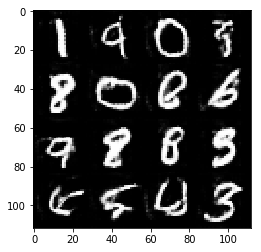

Epoch 2/2..., step 1510 Discriminator Loss: 1.3466... Generator Loss: 0.8254
Epoch 2/2..., step 1520 Discriminator Loss: 1.4002... Generator Loss: 0.9209
Epoch 2/2..., step 1530 Discriminator Loss: 1.3385... Generator Loss: 0.7159
Epoch 2/2..., step 1540 Discriminator Loss: 1.2569... Generator Loss: 0.8215
Epoch 2/2..., step 1550 Discriminator Loss: 1.5081... Generator Loss: 0.4451
Epoch 2/2..., step 1560 Discriminator Loss: 1.3447... Generator Loss: 0.7428
Epoch 2/2..., step 1570 Discriminator Loss: 1.3457... Generator Loss: 0.8239
Epoch 2/2..., step 1580 Discriminator Loss: 1.3260... Generator Loss: 0.8063
Epoch 2/2..., step 1590 Discriminator Loss: 1.4163... Generator Loss: 0.6707
Epoch 2/2..., step 1600 Discriminator Loss: 1.3029... Generator Loss: 0.7768


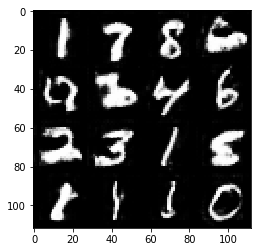

Epoch 2/2..., step 1610 Discriminator Loss: 1.3499... Generator Loss: 0.7634
Epoch 2/2..., step 1620 Discriminator Loss: 1.3497... Generator Loss: 0.6906
Epoch 2/2..., step 1630 Discriminator Loss: 1.3162... Generator Loss: 0.7278
Epoch 2/2..., step 1640 Discriminator Loss: 1.3178... Generator Loss: 0.7902
Epoch 2/2..., step 1650 Discriminator Loss: 1.3169... Generator Loss: 1.0577


In [ ]:
batch_size = 64
z_dim = 32
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1..., step 10 Discriminator Loss: 0.4291... Generator Loss: 3.4364
Epoch 1/1..., step 20 Discriminator Loss: 1.5515... Generator Loss: 0.4989
Epoch 1/1..., step 30 Discriminator Loss: 0.7592... Generator Loss: 1.9088
Epoch 1/1..., step 40 Discriminator Loss: 1.3072... Generator Loss: 1.1195
Epoch 1/1..., step 50 Discriminator Loss: 1.6030... Generator Loss: 0.7314
Epoch 1/1..., step 60 Discriminator Loss: 1.6192... Generator Loss: 1.0404
Epoch 1/1..., step 70 Discriminator Loss: 1.5303... Generator Loss: 1.7722
Epoch 1/1..., step 80 Discriminator Loss: 1.0813... Generator Loss: 1.0140
Epoch 1/1..., step 90 Discriminator Loss: 1.2640... Generator Loss: 1.4571
Epoch 1/1..., step 100 Discriminator Loss: 1.8244... Generator Loss: 0.6874


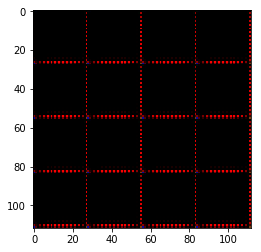

Epoch 1/1..., step 110 Discriminator Loss: 1.6140... Generator Loss: 1.9138
Epoch 1/1..., step 120 Discriminator Loss: 1.6151... Generator Loss: 0.7377
Epoch 1/1..., step 130 Discriminator Loss: 1.1503... Generator Loss: 1.2269
Epoch 1/1..., step 140 Discriminator Loss: 1.3869... Generator Loss: 0.9238
Epoch 1/1..., step 150 Discriminator Loss: 1.3063... Generator Loss: 0.9070
Epoch 1/1..., step 160 Discriminator Loss: 1.4354... Generator Loss: 1.0322
Epoch 1/1..., step 170 Discriminator Loss: 1.3079... Generator Loss: 1.2611
Epoch 1/1..., step 180 Discriminator Loss: 1.3138... Generator Loss: 0.8522
Epoch 1/1..., step 190 Discriminator Loss: 1.5809... Generator Loss: 0.5334
Epoch 1/1..., step 200 Discriminator Loss: 1.1704... Generator Loss: 0.8967


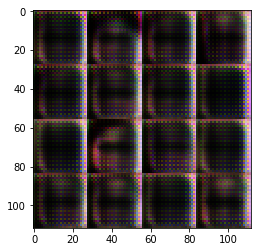

Epoch 1/1..., step 210 Discriminator Loss: 1.2309... Generator Loss: 1.0672
Epoch 1/1..., step 220 Discriminator Loss: 1.6078... Generator Loss: 0.4656
Epoch 1/1..., step 230 Discriminator Loss: 1.1808... Generator Loss: 1.1951
Epoch 1/1..., step 240 Discriminator Loss: 1.7725... Generator Loss: 0.3395
Epoch 1/1..., step 250 Discriminator Loss: 1.9340... Generator Loss: 1.3852
Epoch 1/1..., step 260 Discriminator Loss: 1.6106... Generator Loss: 0.5202
Epoch 1/1..., step 270 Discriminator Loss: 1.5182... Generator Loss: 1.0374
Epoch 1/1..., step 280 Discriminator Loss: 1.2997... Generator Loss: 0.6676
Epoch 1/1..., step 290 Discriminator Loss: 1.0067... Generator Loss: 2.7162
Epoch 1/1..., step 300 Discriminator Loss: 1.9790... Generator Loss: 0.3114


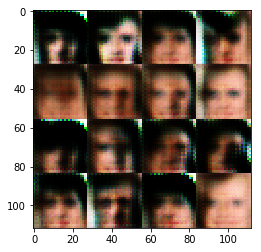

Epoch 1/1..., step 310 Discriminator Loss: 1.1822... Generator Loss: 0.8032
Epoch 1/1..., step 320 Discriminator Loss: 1.8282... Generator Loss: 0.3371
Epoch 1/1..., step 330 Discriminator Loss: 1.3912... Generator Loss: 0.6717
Epoch 1/1..., step 340 Discriminator Loss: 1.2747... Generator Loss: 0.6145
Epoch 1/1..., step 350 Discriminator Loss: 1.4231... Generator Loss: 1.6624
Epoch 1/1..., step 360 Discriminator Loss: 1.3011... Generator Loss: 1.2920
Epoch 1/1..., step 370 Discriminator Loss: 1.0835... Generator Loss: 0.9224
Epoch 1/1..., step 380 Discriminator Loss: 1.2250... Generator Loss: 1.0065
Epoch 1/1..., step 390 Discriminator Loss: 1.5812... Generator Loss: 0.6431
Epoch 1/1..., step 400 Discriminator Loss: 1.3408... Generator Loss: 0.9432


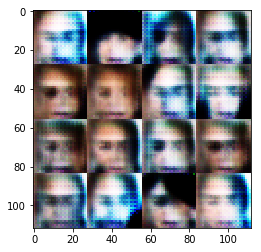

Epoch 1/1..., step 410 Discriminator Loss: 1.2580... Generator Loss: 1.2440
Epoch 1/1..., step 420 Discriminator Loss: 1.1612... Generator Loss: 1.0925
Epoch 1/1..., step 430 Discriminator Loss: 1.5372... Generator Loss: 0.4532
Epoch 1/1..., step 440 Discriminator Loss: 1.4800... Generator Loss: 0.6933
Epoch 1/1..., step 450 Discriminator Loss: 1.7892... Generator Loss: 0.4127
Epoch 1/1..., step 460 Discriminator Loss: 1.2626... Generator Loss: 0.8026
Epoch 1/1..., step 470 Discriminator Loss: 1.4357... Generator Loss: 0.6972
Epoch 1/1..., step 480 Discriminator Loss: 1.0964... Generator Loss: 1.2035
Epoch 1/1..., step 490 Discriminator Loss: 1.5522... Generator Loss: 0.4804
Epoch 1/1..., step 500 Discriminator Loss: 1.5861... Generator Loss: 0.6821


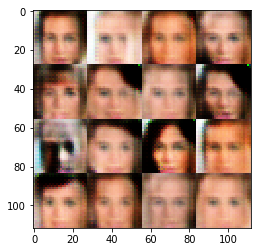

Epoch 1/1..., step 510 Discriminator Loss: 1.3633... Generator Loss: 0.7058
Epoch 1/1..., step 520 Discriminator Loss: 1.7681... Generator Loss: 1.1620
Epoch 1/1..., step 530 Discriminator Loss: 1.4958... Generator Loss: 0.7248
Epoch 1/1..., step 540 Discriminator Loss: 1.0223... Generator Loss: 1.2737
Epoch 1/1..., step 550 Discriminator Loss: 1.3661... Generator Loss: 0.9202
Epoch 1/1..., step 560 Discriminator Loss: 1.5605... Generator Loss: 0.4980
Epoch 1/1..., step 570 Discriminator Loss: 1.1309... Generator Loss: 1.0724
Epoch 1/1..., step 580 Discriminator Loss: 1.3222... Generator Loss: 1.0558
Epoch 1/1..., step 590 Discriminator Loss: 1.3147... Generator Loss: 0.7965
Epoch 1/1..., step 600 Discriminator Loss: 1.6600... Generator Loss: 0.4792


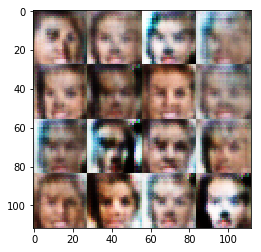

Epoch 1/1..., step 610 Discriminator Loss: 1.5272... Generator Loss: 0.7124
Epoch 1/1..., step 620 Discriminator Loss: 1.3452... Generator Loss: 0.7456
Epoch 1/1..., step 630 Discriminator Loss: 1.1923... Generator Loss: 1.8602
Epoch 1/1..., step 640 Discriminator Loss: 1.5820... Generator Loss: 0.5467
Epoch 1/1..., step 650 Discriminator Loss: 1.3407... Generator Loss: 0.8684
Epoch 1/1..., step 660 Discriminator Loss: 1.4057... Generator Loss: 0.7320
Epoch 1/1..., step 670 Discriminator Loss: 1.4174... Generator Loss: 0.6756
Epoch 1/1..., step 680 Discriminator Loss: 1.3608... Generator Loss: 0.7002
Epoch 1/1..., step 690 Discriminator Loss: 1.5272... Generator Loss: 0.6140
Epoch 1/1..., step 700 Discriminator Loss: 1.4078... Generator Loss: 0.9486


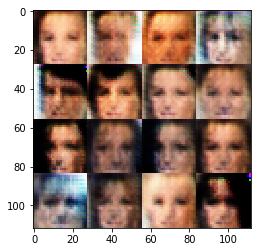

Epoch 1/1..., step 710 Discriminator Loss: 1.7290... Generator Loss: 0.3789
Epoch 1/1..., step 720 Discriminator Loss: 1.2715... Generator Loss: 0.8969
Epoch 1/1..., step 730 Discriminator Loss: 1.7831... Generator Loss: 0.3944
Epoch 1/1..., step 740 Discriminator Loss: 1.3574... Generator Loss: 0.8539
Epoch 1/1..., step 750 Discriminator Loss: 1.5732... Generator Loss: 0.5909
Epoch 1/1..., step 760 Discriminator Loss: 1.4293... Generator Loss: 0.9346
Epoch 1/1..., step 770 Discriminator Loss: 1.5316... Generator Loss: 0.7557
Epoch 1/1..., step 780 Discriminator Loss: 1.3271... Generator Loss: 0.6886
Epoch 1/1..., step 790 Discriminator Loss: 1.3909... Generator Loss: 0.7746
Epoch 1/1..., step 800 Discriminator Loss: 1.5579... Generator Loss: 0.8240


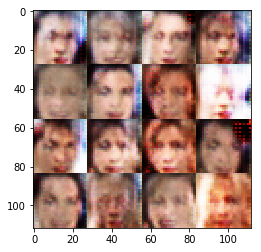

Epoch 1/1..., step 810 Discriminator Loss: 1.3902... Generator Loss: 0.8332
Epoch 1/1..., step 820 Discriminator Loss: 1.4873... Generator Loss: 0.8012
Epoch 1/1..., step 830 Discriminator Loss: 1.3668... Generator Loss: 0.7642
Epoch 1/1..., step 840 Discriminator Loss: 0.9516... Generator Loss: 1.1207
Epoch 1/1..., step 850 Discriminator Loss: 1.3134... Generator Loss: 0.7874
Epoch 1/1..., step 860 Discriminator Loss: 1.1972... Generator Loss: 1.1625
Epoch 1/1..., step 870 Discriminator Loss: 1.5515... Generator Loss: 0.5245
Epoch 1/1..., step 880 Discriminator Loss: 1.4707... Generator Loss: 1.0019
Epoch 1/1..., step 890 Discriminator Loss: 1.4283... Generator Loss: 0.8276
Epoch 1/1..., step 900 Discriminator Loss: 1.4437... Generator Loss: 0.7134


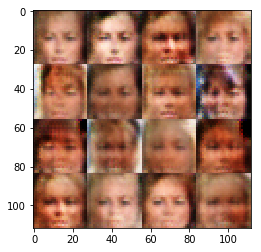

Epoch 1/1..., step 910 Discriminator Loss: 1.4149... Generator Loss: 0.7599
Epoch 1/1..., step 920 Discriminator Loss: 1.6576... Generator Loss: 0.6040
Epoch 1/1..., step 930 Discriminator Loss: 1.3524... Generator Loss: 0.7555
Epoch 1/1..., step 940 Discriminator Loss: 1.3860... Generator Loss: 0.5539
Epoch 1/1..., step 950 Discriminator Loss: 1.4240... Generator Loss: 0.6736
Epoch 1/1..., step 960 Discriminator Loss: 1.5786... Generator Loss: 0.5771
Epoch 1/1..., step 970 Discriminator Loss: 1.5148... Generator Loss: 0.8500
Epoch 1/1..., step 980 Discriminator Loss: 1.1873... Generator Loss: 1.0287
Epoch 1/1..., step 990 Discriminator Loss: 1.5099... Generator Loss: 0.5977
Epoch 1/1..., step 1000 Discriminator Loss: 1.5281... Generator Loss: 0.6494


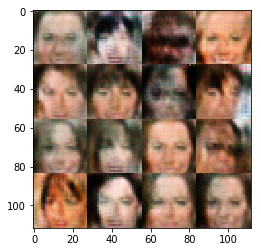

Epoch 1/1..., step 1010 Discriminator Loss: 1.4455... Generator Loss: 0.7089
Epoch 1/1..., step 1020 Discriminator Loss: 1.4713... Generator Loss: 0.7056
Epoch 1/1..., step 1030 Discriminator Loss: 1.4312... Generator Loss: 0.8861
Epoch 1/1..., step 1040 Discriminator Loss: 1.3785... Generator Loss: 0.7285
Epoch 1/1..., step 1050 Discriminator Loss: 1.3388... Generator Loss: 0.8420
Epoch 1/1..., step 1060 Discriminator Loss: 1.2226... Generator Loss: 1.0565
Epoch 1/1..., step 1070 Discriminator Loss: 1.5132... Generator Loss: 0.6719
Epoch 1/1..., step 1080 Discriminator Loss: 1.4741... Generator Loss: 0.7216
Epoch 1/1..., step 1090 Discriminator Loss: 1.4559... Generator Loss: 0.7294
Epoch 1/1..., step 1100 Discriminator Loss: 1.3702... Generator Loss: 0.6815


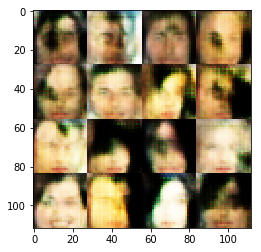

Epoch 1/1..., step 1110 Discriminator Loss: 1.4274... Generator Loss: 0.7788
Epoch 1/1..., step 1120 Discriminator Loss: 1.1504... Generator Loss: 1.0391
Epoch 1/1..., step 1130 Discriminator Loss: 1.2768... Generator Loss: 0.8127
Epoch 1/1..., step 1140 Discriminator Loss: 1.2625... Generator Loss: 0.9655
Epoch 1/1..., step 1150 Discriminator Loss: 1.3828... Generator Loss: 0.7781
Epoch 1/1..., step 1160 Discriminator Loss: 1.5356... Generator Loss: 0.5614
Epoch 1/1..., step 1170 Discriminator Loss: 1.1808... Generator Loss: 1.0714
Epoch 1/1..., step 1180 Discriminator Loss: 1.3874... Generator Loss: 0.6690
Epoch 1/1..., step 1190 Discriminator Loss: 1.4197... Generator Loss: 0.7563
Epoch 1/1..., step 1200 Discriminator Loss: 1.5569... Generator Loss: 0.7143


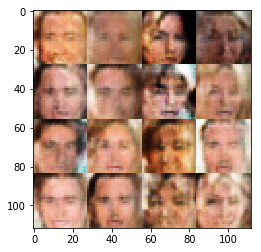

Epoch 1/1..., step 1210 Discriminator Loss: 1.3176... Generator Loss: 0.8232
Epoch 1/1..., step 1220 Discriminator Loss: 1.4987... Generator Loss: 0.6650
Epoch 1/1..., step 1230 Discriminator Loss: 1.4522... Generator Loss: 0.7320
Epoch 1/1..., step 1240 Discriminator Loss: 1.5049... Generator Loss: 0.6996
Epoch 1/1..., step 1250 Discriminator Loss: 1.3236... Generator Loss: 0.7776
Epoch 1/1..., step 1260 Discriminator Loss: 1.3137... Generator Loss: 1.0358
Epoch 1/1..., step 1270 Discriminator Loss: 1.4078... Generator Loss: 0.8863
Epoch 1/1..., step 1280 Discriminator Loss: 1.5041... Generator Loss: 0.8262
Epoch 1/1..., step 1290 Discriminator Loss: 1.3226... Generator Loss: 0.8980
Epoch 1/1..., step 1300 Discriminator Loss: 1.3147... Generator Loss: 0.7686


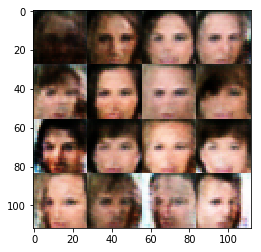

Epoch 1/1..., step 1310 Discriminator Loss: 1.4400... Generator Loss: 0.7604
Epoch 1/1..., step 1320 Discriminator Loss: 1.4076... Generator Loss: 0.6619
Epoch 1/1..., step 1330 Discriminator Loss: 1.3959... Generator Loss: 0.7838
Epoch 1/1..., step 1340 Discriminator Loss: 1.3882... Generator Loss: 0.7423
Epoch 1/1..., step 1350 Discriminator Loss: 1.2516... Generator Loss: 0.8670
Epoch 1/1..., step 1360 Discriminator Loss: 1.3035... Generator Loss: 0.8239
Epoch 1/1..., step 1370 Discriminator Loss: 1.4328... Generator Loss: 0.9449
Epoch 1/1..., step 1380 Discriminator Loss: 1.2870... Generator Loss: 0.7759
Epoch 1/1..., step 1390 Discriminator Loss: 1.3042... Generator Loss: 0.9745
Epoch 1/1..., step 1400 Discriminator Loss: 1.4380... Generator Loss: 0.7154


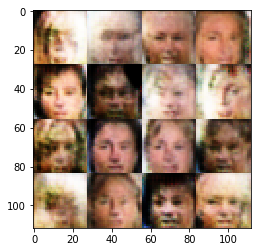

Epoch 1/1..., step 1410 Discriminator Loss: 1.3546... Generator Loss: 0.7795
Epoch 1/1..., step 1420 Discriminator Loss: 1.5417... Generator Loss: 0.5923
Epoch 1/1..., step 1430 Discriminator Loss: 1.5380... Generator Loss: 0.6602
Epoch 1/1..., step 1440 Discriminator Loss: 1.2265... Generator Loss: 0.8779
Epoch 1/1..., step 1450 Discriminator Loss: 1.2641... Generator Loss: 0.6649
Epoch 1/1..., step 1460 Discriminator Loss: 1.6224... Generator Loss: 0.4372
Epoch 1/1..., step 1470 Discriminator Loss: 1.4094... Generator Loss: 0.7814
Epoch 1/1..., step 1480 Discriminator Loss: 1.4928... Generator Loss: 0.8945
Epoch 1/1..., step 1490 Discriminator Loss: 1.3018... Generator Loss: 0.8662
Epoch 1/1..., step 1500 Discriminator Loss: 1.1608... Generator Loss: 1.0305


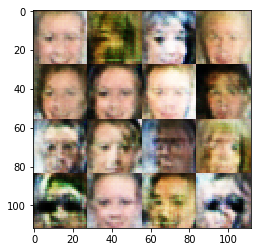

Epoch 1/1..., step 1510 Discriminator Loss: 1.3466... Generator Loss: 0.8436
Epoch 1/1..., step 1520 Discriminator Loss: 1.3788... Generator Loss: 0.7298
Epoch 1/1..., step 1530 Discriminator Loss: 1.4582... Generator Loss: 0.6175
Epoch 1/1..., step 1540 Discriminator Loss: 1.5050... Generator Loss: 0.5378
Epoch 1/1..., step 1550 Discriminator Loss: 1.2943... Generator Loss: 0.7294
Epoch 1/1..., step 1560 Discriminator Loss: 1.1540... Generator Loss: 1.0628
Epoch 1/1..., step 1570 Discriminator Loss: 1.4042... Generator Loss: 0.7883
Epoch 1/1..., step 1580 Discriminator Loss: 1.4195... Generator Loss: 0.6055
Epoch 1/1..., step 1590 Discriminator Loss: 1.4204... Generator Loss: 0.5911
Epoch 1/1..., step 1600 Discriminator Loss: 1.3209... Generator Loss: 0.8459


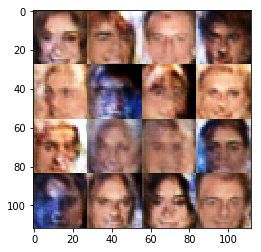

Epoch 1/1..., step 1610 Discriminator Loss: 1.3884... Generator Loss: 0.7700
Epoch 1/1..., step 1620 Discriminator Loss: 1.3742... Generator Loss: 0.7282
Epoch 1/1..., step 1630 Discriminator Loss: 1.3887... Generator Loss: 0.8530
Epoch 1/1..., step 1640 Discriminator Loss: 1.4582... Generator Loss: 0.7514
Epoch 1/1..., step 1650 Discriminator Loss: 1.1770... Generator Loss: 0.8080
Epoch 1/1..., step 1660 Discriminator Loss: 1.3595... Generator Loss: 1.4763
Epoch 1/1..., step 1670 Discriminator Loss: 1.2796... Generator Loss: 0.9731
Epoch 1/1..., step 1680 Discriminator Loss: 1.3959... Generator Loss: 0.8966
Epoch 1/1..., step 1690 Discriminator Loss: 1.3643... Generator Loss: 0.8115
Epoch 1/1..., step 1700 Discriminator Loss: 1.3497... Generator Loss: 1.0312


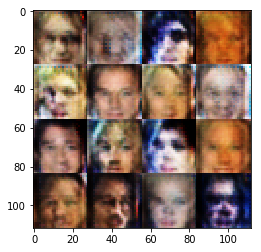

Epoch 1/1..., step 1710 Discriminator Loss: 1.3513... Generator Loss: 0.9235
Epoch 1/1..., step 1720 Discriminator Loss: 1.3545... Generator Loss: 0.7005
Epoch 1/1..., step 1730 Discriminator Loss: 1.4345... Generator Loss: 0.6264
Epoch 1/1..., step 1740 Discriminator Loss: 1.4269... Generator Loss: 0.6600
Epoch 1/1..., step 1750 Discriminator Loss: 1.4052... Generator Loss: 0.7209
Epoch 1/1..., step 1760 Discriminator Loss: 1.2815... Generator Loss: 0.8551
Epoch 1/1..., step 1770 Discriminator Loss: 1.5140... Generator Loss: 0.7232
Epoch 1/1..., step 1780 Discriminator Loss: 1.3681... Generator Loss: 0.7580
Epoch 1/1..., step 1790 Discriminator Loss: 1.4029... Generator Loss: 0.8010
Epoch 1/1..., step 1800 Discriminator Loss: 1.4294... Generator Loss: 0.6613


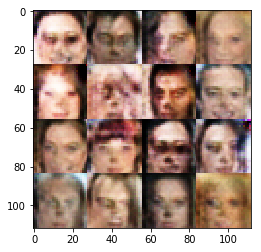

Epoch 1/1..., step 1810 Discriminator Loss: 1.4507... Generator Loss: 0.8212
Epoch 1/1..., step 1820 Discriminator Loss: 1.2999... Generator Loss: 0.9470
Epoch 1/1..., step 1830 Discriminator Loss: 1.3715... Generator Loss: 0.8643
Epoch 1/1..., step 1840 Discriminator Loss: 1.3573... Generator Loss: 0.7493
Epoch 1/1..., step 1850 Discriminator Loss: 1.3810... Generator Loss: 0.6940
Epoch 1/1..., step 1860 Discriminator Loss: 1.3049... Generator Loss: 0.8711
Epoch 1/1..., step 1870 Discriminator Loss: 1.4606... Generator Loss: 0.5440
Epoch 1/1..., step 1880 Discriminator Loss: 1.3778... Generator Loss: 0.7858
Epoch 1/1..., step 1890 Discriminator Loss: 1.3420... Generator Loss: 0.7152
Epoch 1/1..., step 1900 Discriminator Loss: 1.3850... Generator Loss: 0.7563


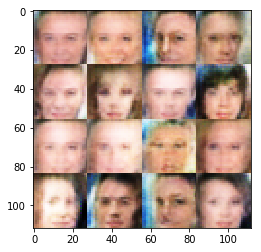

Epoch 1/1..., step 1910 Discriminator Loss: 1.4268... Generator Loss: 0.6883
Epoch 1/1..., step 1920 Discriminator Loss: 1.5146... Generator Loss: 0.6236
Epoch 1/1..., step 1930 Discriminator Loss: 1.3552... Generator Loss: 0.7922
Epoch 1/1..., step 1940 Discriminator Loss: 1.3337... Generator Loss: 0.8877
Epoch 1/1..., step 1950 Discriminator Loss: 1.4357... Generator Loss: 0.7918
Epoch 1/1..., step 1960 Discriminator Loss: 1.4262... Generator Loss: 0.7944
Epoch 1/1..., step 1970 Discriminator Loss: 1.1849... Generator Loss: 1.3795
Epoch 1/1..., step 1980 Discriminator Loss: 1.4566... Generator Loss: 0.9025
Epoch 1/1..., step 1990 Discriminator Loss: 1.4695... Generator Loss: 0.6271
Epoch 1/1..., step 2000 Discriminator Loss: 1.4508... Generator Loss: 0.6817


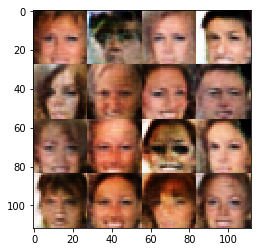

Epoch 1/1..., step 2010 Discriminator Loss: 1.4379... Generator Loss: 0.6699
Epoch 1/1..., step 2020 Discriminator Loss: 1.3672... Generator Loss: 0.7935
Epoch 1/1..., step 2030 Discriminator Loss: 1.5528... Generator Loss: 0.4376
Epoch 1/1..., step 2040 Discriminator Loss: 1.4571... Generator Loss: 0.6615
Epoch 1/1..., step 2050 Discriminator Loss: 1.4049... Generator Loss: 0.8886
Epoch 1/1..., step 2060 Discriminator Loss: 1.3570... Generator Loss: 0.7908
Epoch 1/1..., step 2070 Discriminator Loss: 1.3927... Generator Loss: 0.5673
Epoch 1/1..., step 2080 Discriminator Loss: 1.3612... Generator Loss: 0.8533
Epoch 1/1..., step 2090 Discriminator Loss: 1.3207... Generator Loss: 0.9121
Epoch 1/1..., step 2100 Discriminator Loss: 1.3271... Generator Loss: 1.0455


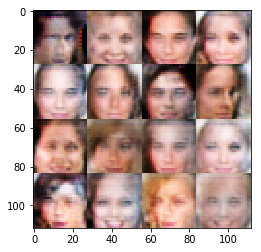

Epoch 1/1..., step 2110 Discriminator Loss: 1.4197... Generator Loss: 0.5839
Epoch 1/1..., step 2120 Discriminator Loss: 1.3949... Generator Loss: 1.1754
Epoch 1/1..., step 2130 Discriminator Loss: 1.4166... Generator Loss: 0.6087
Epoch 1/1..., step 2140 Discriminator Loss: 1.3363... Generator Loss: 0.7904
Epoch 1/1..., step 2150 Discriminator Loss: 1.3344... Generator Loss: 0.8665
Epoch 1/1..., step 2160 Discriminator Loss: 1.3189... Generator Loss: 0.7368
Epoch 1/1..., step 2170 Discriminator Loss: 1.2771... Generator Loss: 0.7689
Epoch 1/1..., step 2180 Discriminator Loss: 1.4546... Generator Loss: 0.5891
Epoch 1/1..., step 2190 Discriminator Loss: 1.2765... Generator Loss: 1.4772
Epoch 1/1..., step 2200 Discriminator Loss: 1.4915... Generator Loss: 0.5660


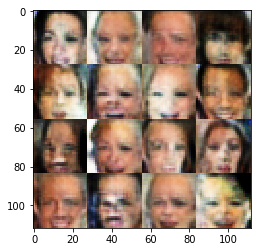

Epoch 1/1..., step 2210 Discriminator Loss: 1.3337... Generator Loss: 0.8665
Epoch 1/1..., step 2220 Discriminator Loss: 1.5442... Generator Loss: 0.4576
Epoch 1/1..., step 2230 Discriminator Loss: 1.4747... Generator Loss: 0.7037
Epoch 1/1..., step 2240 Discriminator Loss: 1.3332... Generator Loss: 1.0544
Epoch 1/1..., step 2250 Discriminator Loss: 1.3422... Generator Loss: 0.8190
Epoch 1/1..., step 2260 Discriminator Loss: 1.4388... Generator Loss: 0.7262
Epoch 1/1..., step 2270 Discriminator Loss: 1.3708... Generator Loss: 0.7670
Epoch 1/1..., step 2280 Discriminator Loss: 1.4330... Generator Loss: 0.7049
Epoch 1/1..., step 2290 Discriminator Loss: 1.3170... Generator Loss: 0.8850
Epoch 1/1..., step 2300 Discriminator Loss: 1.3587... Generator Loss: 0.8049


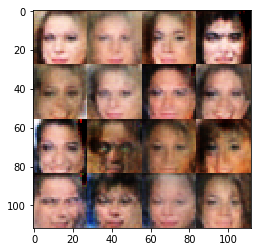

Epoch 1/1..., step 2310 Discriminator Loss: 1.3741... Generator Loss: 0.6895
Epoch 1/1..., step 2320 Discriminator Loss: 1.2771... Generator Loss: 0.8416
Epoch 1/1..., step 2330 Discriminator Loss: 1.3765... Generator Loss: 0.8575
Epoch 1/1..., step 2340 Discriminator Loss: 1.4881... Generator Loss: 0.6291
Epoch 1/1..., step 2350 Discriminator Loss: 1.4685... Generator Loss: 0.6182
Epoch 1/1..., step 2360 Discriminator Loss: 1.4400... Generator Loss: 0.6426
Epoch 1/1..., step 2370 Discriminator Loss: 1.2909... Generator Loss: 0.7826
Epoch 1/1..., step 2380 Discriminator Loss: 1.2620... Generator Loss: 0.8964
Epoch 1/1..., step 2390 Discriminator Loss: 1.3348... Generator Loss: 0.8615
Epoch 1/1..., step 2400 Discriminator Loss: 1.4543... Generator Loss: 0.7053


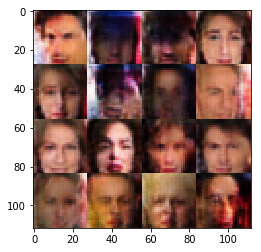

Epoch 1/1..., step 2410 Discriminator Loss: 1.3692... Generator Loss: 0.7812
Epoch 1/1..., step 2420 Discriminator Loss: 1.4115... Generator Loss: 0.9368
Epoch 1/1..., step 2430 Discriminator Loss: 1.1681... Generator Loss: 1.4888
Epoch 1/1..., step 2440 Discriminator Loss: 1.3282... Generator Loss: 0.7901
Epoch 1/1..., step 2450 Discriminator Loss: 1.2804... Generator Loss: 0.9086
Epoch 1/1..., step 2460 Discriminator Loss: 1.3079... Generator Loss: 0.8590
Epoch 1/1..., step 2470 Discriminator Loss: 1.5156... Generator Loss: 0.4971
Epoch 1/1..., step 2480 Discriminator Loss: 1.3871... Generator Loss: 0.8817
Epoch 1/1..., step 2490 Discriminator Loss: 1.3829... Generator Loss: 0.6434
Epoch 1/1..., step 2500 Discriminator Loss: 1.3990... Generator Loss: 0.7362


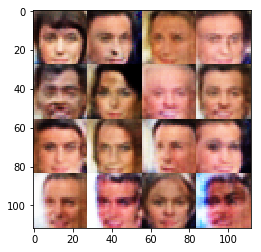

Epoch 1/1..., step 2510 Discriminator Loss: 1.1493... Generator Loss: 0.8287
Epoch 1/1..., step 2520 Discriminator Loss: 1.3313... Generator Loss: 0.7555
Epoch 1/1..., step 2530 Discriminator Loss: 1.4560... Generator Loss: 0.5929
Epoch 1/1..., step 2540 Discriminator Loss: 1.4297... Generator Loss: 0.6010
Epoch 1/1..., step 2550 Discriminator Loss: 1.4737... Generator Loss: 0.6670
Epoch 1/1..., step 2560 Discriminator Loss: 1.3809... Generator Loss: 0.9074
Epoch 1/1..., step 2570 Discriminator Loss: 1.5056... Generator Loss: 0.5617
Epoch 1/1..., step 2580 Discriminator Loss: 1.4920... Generator Loss: 0.5970
Epoch 1/1..., step 2590 Discriminator Loss: 1.3455... Generator Loss: 0.7404
Epoch 1/1..., step 2600 Discriminator Loss: 1.3149... Generator Loss: 0.7649


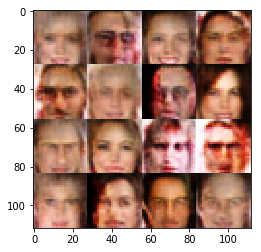

Epoch 1/1..., step 2610 Discriminator Loss: 1.4404... Generator Loss: 0.6234
Epoch 1/1..., step 2620 Discriminator Loss: 1.4428... Generator Loss: 0.7218
Epoch 1/1..., step 2630 Discriminator Loss: 1.4175... Generator Loss: 0.6259
Epoch 1/1..., step 2640 Discriminator Loss: 1.4076... Generator Loss: 0.6518
Epoch 1/1..., step 2650 Discriminator Loss: 1.3903... Generator Loss: 0.6786
Epoch 1/1..., step 2660 Discriminator Loss: 1.3631... Generator Loss: 0.6830
Epoch 1/1..., step 2670 Discriminator Loss: 1.3732... Generator Loss: 0.8277
Epoch 1/1..., step 2680 Discriminator Loss: 1.4904... Generator Loss: 0.6337
Epoch 1/1..., step 2690 Discriminator Loss: 1.3427... Generator Loss: 0.8061
Epoch 1/1..., step 2700 Discriminator Loss: 1.3858... Generator Loss: 0.7062


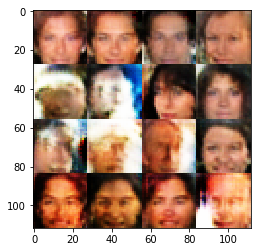

Epoch 1/1..., step 2710 Discriminator Loss: 1.3642... Generator Loss: 0.5693
Epoch 1/1..., step 2720 Discriminator Loss: 1.3708... Generator Loss: 0.6138
Epoch 1/1..., step 2730 Discriminator Loss: 1.3098... Generator Loss: 0.8577
Epoch 1/1..., step 2740 Discriminator Loss: 1.3703... Generator Loss: 1.0761
Epoch 1/1..., step 2750 Discriminator Loss: 1.4044... Generator Loss: 0.7151
Epoch 1/1..., step 2760 Discriminator Loss: 1.4286... Generator Loss: 0.7001
Epoch 1/1..., step 2770 Discriminator Loss: 1.4585... Generator Loss: 0.6263
Epoch 1/1..., step 2780 Discriminator Loss: 1.2914... Generator Loss: 0.8016
Epoch 1/1..., step 2790 Discriminator Loss: 1.3585... Generator Loss: 0.7536
Epoch 1/1..., step 2800 Discriminator Loss: 1.4053... Generator Loss: 0.7414


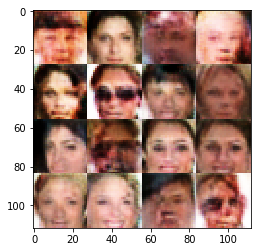

Epoch 1/1..., step 2810 Discriminator Loss: 1.3830... Generator Loss: 0.6258
Epoch 1/1..., step 2820 Discriminator Loss: 1.4191... Generator Loss: 0.7869
Epoch 1/1..., step 2830 Discriminator Loss: 1.4172... Generator Loss: 0.7208
Epoch 1/1..., step 2840 Discriminator Loss: 1.4663... Generator Loss: 0.6285
Epoch 1/1..., step 2850 Discriminator Loss: 1.4874... Generator Loss: 0.5574
Epoch 1/1..., step 2860 Discriminator Loss: 1.4222... Generator Loss: 0.8038
Epoch 1/1..., step 2870 Discriminator Loss: 1.3423... Generator Loss: 0.8436
Epoch 1/1..., step 2880 Discriminator Loss: 1.3962... Generator Loss: 0.7328
Epoch 1/1..., step 2890 Discriminator Loss: 1.3101... Generator Loss: 0.7964
Epoch 1/1..., step 2900 Discriminator Loss: 1.3791... Generator Loss: 0.7900


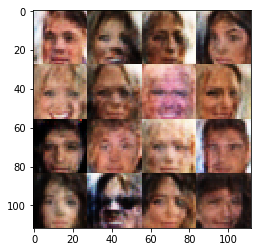

Epoch 1/1..., step 2910 Discriminator Loss: 1.3817... Generator Loss: 0.6929
Epoch 1/1..., step 2920 Discriminator Loss: 1.5578... Generator Loss: 0.4143
Epoch 1/1..., step 2930 Discriminator Loss: 1.3917... Generator Loss: 0.7218
Epoch 1/1..., step 2940 Discriminator Loss: 1.3949... Generator Loss: 0.7234
Epoch 1/1..., step 2950 Discriminator Loss: 1.4424... Generator Loss: 0.7529
Epoch 1/1..., step 2960 Discriminator Loss: 1.4006... Generator Loss: 0.7023
Epoch 1/1..., step 2970 Discriminator Loss: 1.4005... Generator Loss: 0.6554
Epoch 1/1..., step 2980 Discriminator Loss: 1.2858... Generator Loss: 1.0054
Epoch 1/1..., step 2990 Discriminator Loss: 1.3844... Generator Loss: 0.6919
Epoch 1/1..., step 3000 Discriminator Loss: 1.4689... Generator Loss: 0.6148


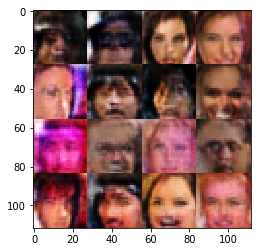

Epoch 1/1..., step 3010 Discriminator Loss: 1.4429... Generator Loss: 0.6559
Epoch 1/1..., step 3020 Discriminator Loss: 1.4048... Generator Loss: 0.7976
Epoch 1/1..., step 3030 Discriminator Loss: 1.3896... Generator Loss: 0.8647
Epoch 1/1..., step 3040 Discriminator Loss: 1.3479... Generator Loss: 0.8456
Epoch 1/1..., step 3050 Discriminator Loss: 1.3785... Generator Loss: 0.6945
Epoch 1/1..., step 3060 Discriminator Loss: 1.4655... Generator Loss: 0.6583
Epoch 1/1..., step 3070 Discriminator Loss: 1.3870... Generator Loss: 0.7552
Epoch 1/1..., step 3080 Discriminator Loss: 1.3680... Generator Loss: 0.8732
Epoch 1/1..., step 3090 Discriminator Loss: 1.3469... Generator Loss: 0.7456
Epoch 1/1..., step 3100 Discriminator Loss: 1.3089... Generator Loss: 0.9009


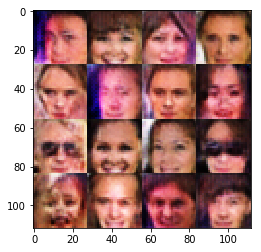

Epoch 1/1..., step 3110 Discriminator Loss: 1.3795... Generator Loss: 0.8298
Epoch 1/1..., step 3120 Discriminator Loss: 1.5220... Generator Loss: 0.6430
Epoch 1/1..., step 3130 Discriminator Loss: 1.3661... Generator Loss: 0.7046
Epoch 1/1..., step 3140 Discriminator Loss: 1.4635... Generator Loss: 0.6380
Epoch 1/1..., step 3150 Discriminator Loss: 1.3252... Generator Loss: 0.8276
Epoch 1/1..., step 3160 Discriminator Loss: 1.4162... Generator Loss: 0.9118


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.